# Bibliotecas

In [17]:
import numpy as np
from numpy import unique

import pandas as pd

import os

from scipy.optimize import minimize
from scipy import stats
import scipy.stats as stats

from tqdm import tqdm

import warnings

from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNetCV, LassoCV, Lasso, LinearRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import seaborn as sns

import random

import pickle

# 1. Descrição dos Dados

O dataset contém informações tabulares organizadas em arquivo no formato CSV. Ele compreende diversas variáveis coletadas a partir de instrumentos clínicos
e de pesquisa, totalizando medições relacionadas à demografia, atividade física, saúde mental e comportamental, e características físicas dos participantes.

As variáveis são:

- Demographics: informações sobre idade e sexo dos participantes.

- Internet Use: número de horas de uso diário de computadores e internet.

- Children's Global assessment Scale: escala numérica usada por clínicos para avaliar o funcionamento geral de crianças e adolescentes menores de 18 anos.

- Physical Measures: conjunto de dados sobre pressão arterial, frequência cardíaca, altura, peso e medidas da cintura e quadril.

- FitnessGram Vitals and Treadmill: avaliações de aptidão cardiovascular baseadas em protocolos de esteira.

- FitnessGram Child: dados relacionados à aptidão física de crianças, incluindo capacidade aeróbica, força muscular e flexibilidade.

- Bio-electric impedance Analysis: medições de composição corporal, como IMC, percentual de gordura, massa muscular e conteúdo hídrico.

- Physical Activity Questionnaire: informações sobre a participação das crianças em atividades físicas vigorosas nos últimos sete dias.

- Sleep Disturbance Scale: escala utilizada para categorizar distúrbios do sono em crianças.

- Parent-Child Internet Addiction Test (PCIAT): escala composta por 20 itens para medir características associadas ao uso compulsivo da internet, como dependência e obsessão.

O objetivo do dataset é prever o índice de gravidade de comprometimento (Severity Impairment Index - sii), que é derivado do campo PCIAT-PCIAT_Total. A variável-alvo sii é categórica e possui quatro níveis: 0 (Nenhum), 1 (Leve), 2 (Moderado) e 3 (Grave).


In [18]:
data = pd.read_csv('test.csv')

In [19]:
data.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1.1 Análise do Dicionário dos Dados

In [21]:
data_dictionary = pd.read_csv('data_dictionary.csv')
data_dictionary.head(81)

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
...,...,...,...,...,...,...
76,Sleep Disturbance Scale,SDS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
77,Sleep Disturbance Scale,SDS-SDS_Total_Raw,Total Raw Score,int,NaN,NaN
78,Sleep Disturbance Scale,SDS-SDS_Total_T,Total T-Score,int,NaN,NaN
79,Internet Use,PreInt_EduHx-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


In [22]:
# Verificar se existe alguma linha onde o valor da coluna 'Field' é sii
if (data_dictionary['Field'] == 'sii').any():
    print("A linha com o nome da coluna do target existe.")
else:
    print("Não existe o nome da coluna do target.")


Não existe o nome da coluna do target.


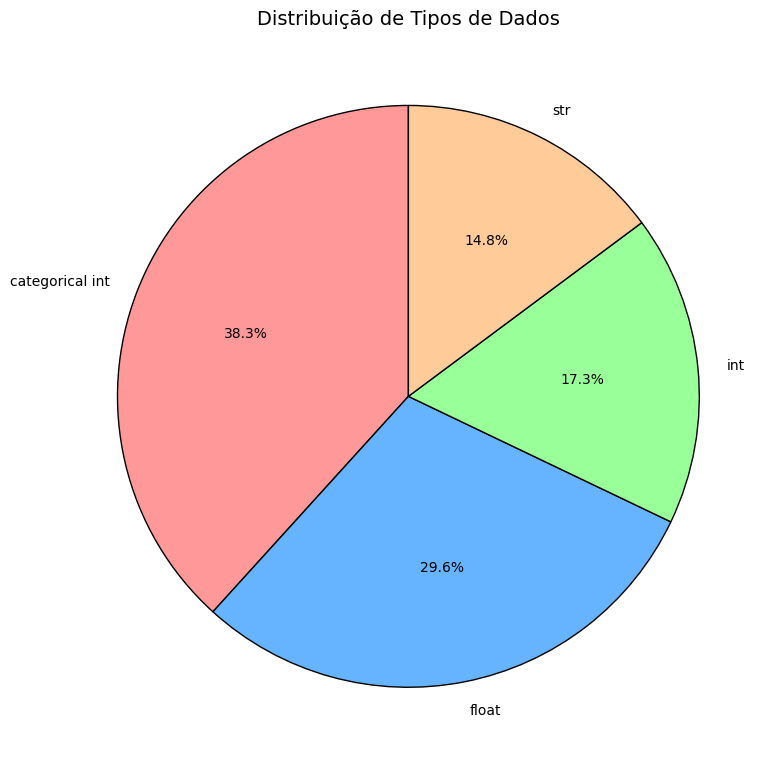

In [23]:
# Contar os valores únicos na coluna 'Type'
type_counts = data_dictionary['Type'].value_counts()

# Definir cores distintas para as fatias da pizza (personalizável)
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', 
          '#ffb3e6', '#c2f0c2', '#c9b6e4', '#f4c2c2', '#f6f6ae', 
          '#add8e6', '#d3d3d3']

# Criar o gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', colors=colors[:len(type_counts)], startangle=90, wedgeprops={'edgecolor': 'black'})

# Adicionar título
plt.title('Distribuição de Tipos de Dados', fontsize=14)

# Ajustar layout
plt.tight_layout()
plt.show()


- Categorical int - dados que estão númericos, mas representão categorias, portanto são dados categóricos.
- str - dados categóricos
- int - númerico Discreto 
- float - númerico contínuo

In [24]:
# Filtrar o DataFrame para incluir apenas linhas onde 'Type' seja 'str' ou 'categorical int'
filtered_1 = data_dictionary[data_dictionary['Type'].isin(['str','categorical int'])]
filtered_2 = data_dictionary[data_dictionary['Type'].isin(['int', 'float'])]

# Obter os valores únicos da coluna 'Field' para essas linhas filtradas
field_list_categorical = filtered_1['Field'].tolist()
field_list_numerical = filtered_2['Field'].tolist()

# Exibir a lista resultante
print(field_list_categorical)
print(field_list_numerical)


['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Sex', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num', 'PAQ_A-Season', 'PAQ_C-Season', 'PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'SDS-Season', 'PreInt_EduHx-Season', 'PreInt_EduHx-computerinternet_hoursday']
['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physic

In [25]:
len(field_list_categorical)

43

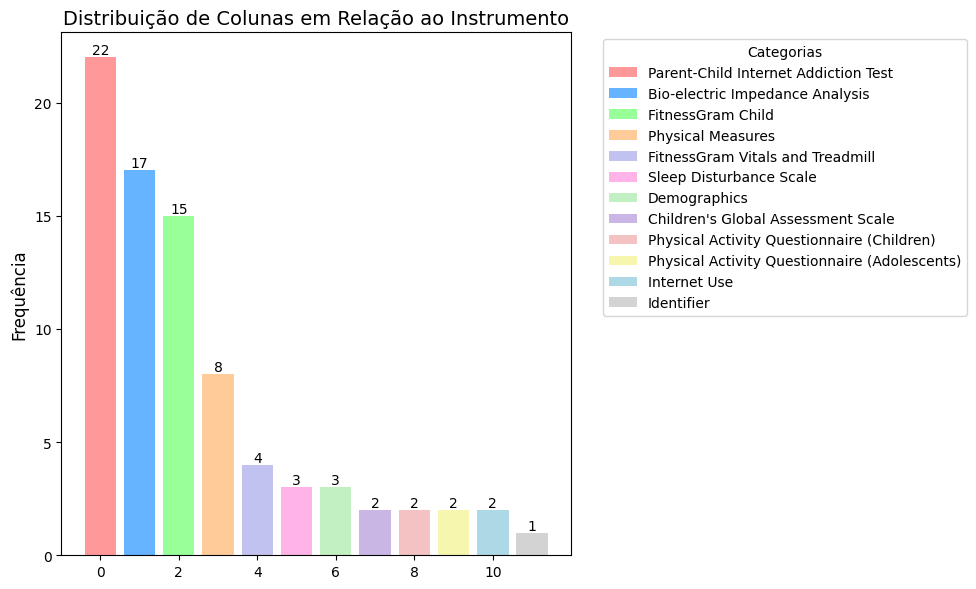

In [26]:
import matplotlib.pyplot as plt

# Contar os valores únicos na primeira coluna
category_counts = data_dictionary['Instrument'].value_counts()

# Definir cores distintas para as barras (personalizável)
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', 
          '#ffb3e6', '#c2f0c2', '#c9b6e4', '#f4c2c2', '#f6f6ae', 
          '#add8e6', '#d3d3d3']

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(category_counts)), category_counts, color=colors[:len(category_counts)])

# Adicionar rótulos e título
plt.ylabel('Frequência', fontsize=12)
plt.title('Distribuição de Colunas em Relação ao Instrumento', fontsize=14)

# Adicionar os valores no topo das barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom', fontsize=10)

# Adicionar uma legenda
legend_labels = [f'{label}' for label in category_counts.index]
plt.legend(bars, legend_labels, title="Categorias", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Ajustar layout para a legenda
plt.tight_layout()
plt.show()


# 2 Preparação dos Dados

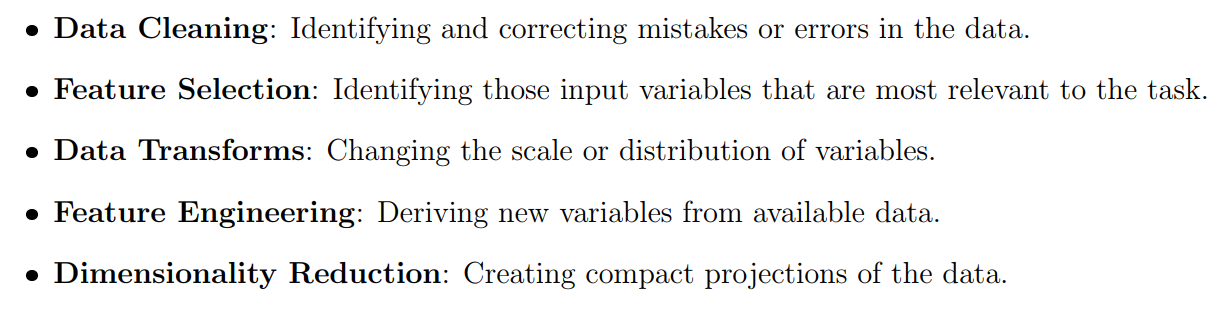

## 2.1 Data Cleaning

### 2.1.1 Basic Data Cleaning

#### 2.1.1.1 Identificar Colunas que Contém um único Valor

In [27]:
# Flag para verificar se há colunas com apenas um valor único
coluna_com_valor_unico = False

# Resumir o número de valores únicos em cada coluna e verificar colunas com um único valor
for i, column in enumerate(data.columns):
    unique_values = data[column].nunique()
    #print(i, column, unique_values)
    
    # Verificar se a coluna tem apenas um valor único
    if unique_values == 1:
       # print(f"  A coluna '{column}' tem apenas um valor único.")
        coluna_com_valor_unico = True

# Mensagem final caso não haja colunas com valor único
if not coluna_com_valor_unico:
    print("Não há nenhuma coluna com um valor único.")


#### 2.1.1.2 Colunas com Muitos Poucos Valores

Aplica-se apenas as colunas númericas.

In [28]:
# Função para resumir a porcentagem de valores únicos para colunas específicas
def analisar_colunas(data, colunas):
    for col in colunas:
        if col in data.columns:
            num_unique = data[col].nunique()  # Número de valores únicos
            percentage = (num_unique / len(data)) * 100  # Porcentagem de valores únicos
            print(f'Coluna: {col}, Valores únicos: {num_unique}, Porcentagem: {percentage:.1f}%')
        else:
            print(f'A coluna "{col}" não está no DataFrame.')

# Chamar a função com o DataFrame e a lista de colunas
analisar_colunas(data, field_list_numerical)


Coluna: Basic_Demos-Age, Valores únicos: 11, Porcentagem: 55.0%
Coluna: CGAS-CGAS_Score, Valores únicos: 6, Porcentagem: 30.0%
Coluna: Physical-BMI, Valores únicos: 13, Porcentagem: 65.0%
Coluna: Physical-Height, Valores únicos: 12, Porcentagem: 60.0%
Coluna: Physical-Weight, Valores únicos: 13, Porcentagem: 65.0%
Coluna: Physical-Waist_Circumference, Valores únicos: 4, Porcentagem: 20.0%
Coluna: Physical-Diastolic_BP, Valores únicos: 9, Porcentagem: 45.0%
Coluna: Physical-HeartRate, Valores únicos: 12, Porcentagem: 60.0%
Coluna: Physical-Systolic_BP, Valores únicos: 10, Porcentagem: 50.0%
Coluna: Fitness_Endurance-Max_Stage, Valores únicos: 3, Porcentagem: 15.0%
Coluna: Fitness_Endurance-Time_Mins, Valores únicos: 3, Porcentagem: 15.0%
Coluna: Fitness_Endurance-Time_Sec, Valores únicos: 3, Porcentagem: 15.0%
Coluna: FGC-FGC_CU, Valores únicos: 10, Porcentagem: 50.0%
Coluna: FGC-FGC_GSND, Valores únicos: 5, Porcentagem: 25.0%
Coluna: FGC-FGC_GSD, Valores únicos: 5, Porcentagem: 25.0%
C

Executando o exemplo, podemos ver que algumas colunas ​​têm variáveis ​​numéricas que têm valores únicos que são menores que 1 por cento do número de linhas. Isso não significa que
essas linhas e colunas devem ser excluídas, mas elas exigem mais atenção. Por exemplo:
- Talvez possam ser codificados como valores ordinais?
- Talvez possam ser codificados como valores categóricos?
- Talvez comparar a habilidade do modelo com cada variável removida do conjunto de dados?

#### 2.1.1.3 Identificando Linhas com Dados Duplicados

In [29]:
# Verificar linhas duplicadas
linhas_duplicadas = data.duplicated()

# Exibir se há linhas duplicadas
if linhas_duplicadas.any():
    print(f'Existem {linhas_duplicadas.sum()} linhas duplicadas.')
    # Exibir as linhas duplicadas (opcional)
    print("\nLinhas duplicadas:")
    print(data[linhas_duplicadas])
else:
    print("Não há linhas duplicadas no DataFrame, portanto.")


Não há linhas duplicadas no DataFrame, portanto.


In [30]:
# Escolher a coluna para verificar
coluna = 'id'  # Substitua pelo nome da coluna

# Verificar valores duplicados na coluna
valores_duplicados = data[coluna].duplicated()

# Exibir resultados
if valores_duplicados.any():
    print(f"A coluna '{coluna}' contém {valores_duplicados.sum()} valores duplicados.")
    # Exibir os valores duplicados (opcional)
    print("\nValores duplicados:")
    print(data[coluna][valores_duplicados].unique())
else:
    print(f"A coluna '{coluna}' não contém valores duplicados.")


A coluna 'id' não contém valores duplicados.


Como cada linha representa um indíviduo, então não há valores duplicados. Verificado o id pra ver se algum id estava repetido.

#### 2.1.1.4 Verificando Valores Faltantes e Padronizando

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   Basic_Demos-Enroll_Season               20 non-null     object 
 2   Basic_Demos-Age                         20 non-null     int64  
 3   Basic_Demos-Sex                         20 non-null     int64  
 4   CGAS-Season                             10 non-null     object 
 5   CGAS-CGAS_Score                         8 non-null      float64
 6   Physical-Season                         14 non-null     object 
 7   Physical-BMI                            13 non-null     float64
 8   Physical-Height                         13 non-null     float64
 9   Physical-Weight                         13 non-null     float64
 10  Physical-Waist_Circumference            5 non-null      float64


In [32]:
data.replace(['', ' ', 'None', 'null'], np.nan, inplace=True)

In [33]:
for col in data.columns:
    # Contar os valores ausentes
    n_miss = data[col].isnull().sum()
    perc = (n_miss / data.shape[0]) * 100
    print(f'> Coluna: {col}, Ausentes: {n_miss} ({perc:.1f}%)')


> Coluna: id, Ausentes: 0 (0.0%)
> Coluna: Basic_Demos-Enroll_Season, Ausentes: 0 (0.0%)
> Coluna: Basic_Demos-Age, Ausentes: 0 (0.0%)
> Coluna: Basic_Demos-Sex, Ausentes: 0 (0.0%)
> Coluna: CGAS-Season, Ausentes: 10 (50.0%)
> Coluna: CGAS-CGAS_Score, Ausentes: 12 (60.0%)
> Coluna: Physical-Season, Ausentes: 6 (30.0%)
> Coluna: Physical-BMI, Ausentes: 7 (35.0%)
> Coluna: Physical-Height, Ausentes: 7 (35.0%)
> Coluna: Physical-Weight, Ausentes: 7 (35.0%)
> Coluna: Physical-Waist_Circumference, Ausentes: 15 (75.0%)
> Coluna: Physical-Diastolic_BP, Ausentes: 9 (45.0%)
> Coluna: Physical-HeartRate, Ausentes: 8 (40.0%)
> Coluna: Physical-Systolic_BP, Ausentes: 9 (45.0%)
> Coluna: Fitness_Endurance-Season, Ausentes: 16 (80.0%)
> Coluna: Fitness_Endurance-Max_Stage, Ausentes: 17 (85.0%)
> Coluna: Fitness_Endurance-Time_Mins, Ausentes: 17 (85.0%)
> Coluna: Fitness_Endurance-Time_Sec, Ausentes: 17 (85.0%)
> Coluna: FGC-Season, Ausentes: 3 (15.0%)
> Coluna: FGC-FGC_CU, Ausentes: 7 (35.0%)
> Colu

## 2.2 Feature Engineering, Feature Selection e Tranformação de Dados

In [34]:
def feature_engineering(df):
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_cols, axis=1) 
    
    # From here on own features
    def assign_group(age):
        thresholds = [5, 6, 7, 8, 10, 12, 14, 17, 22]
        for i, j in enumerate(thresholds):
            if age <= j:
                return i
        return np.nan
    
    # Age groups
    df["group"] = df['Basic_Demos-Age'].apply(assign_group)
    
    # BMI 
    BMI_map = {0: 16.3,1: 15.9,2: 16.1,3: 16.8,4: 17.3,5: 19.2,6: 20.2,7: 22.3, 8: 23.6}
    df['BMI_mean_norm'] = df[['Physical-BMI', 'BIA-BIA_BMI']].mean(axis=1) / df["group"].map(BMI_map)
    
    # FGC zone aggregate
    zones = ['FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone',
             'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone',
             'FGC-FGC_TL_Zone']
    
    df['FGC_Zones_mean'] = df[zones].mean(axis=1)
    df['FGC_Zones_min'] = df[zones].min(axis=1)
    df['FGC_Zones_max'] = df[zones].max(axis=1)
    
    # Grip
    GSD_max_map = {0: 9, 1: 9, 2: 9, 3: 9, 4: 16.2, 5: 19.9, 6: 26.1, 7: 31.3, 8: 35.4}
    GSD_min_map = {0: 9, 1: 9, 2: 9, 3: 9, 4: 14.4, 5: 17.8, 6: 23.4, 7: 27.8, 8: 31.1}
    
    df['GS_max'] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].max(axis=1) / df["group"].map(GSD_max_map)
    df['GS_min'] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].min(axis=1) / df["group"].map(GSD_min_map)
    
    # Curl-ups, push-ups, trunk-lifts... normalized based on age-group
    cu_map = {0: 1.0, 1: 3.0, 2: 5.0, 3: 7.0, 4: 10.0, 5: 14.0, 6: 20.0, 7: 20.0, 8: 20.0}
    pu_map = {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0, 6: 8.0, 7: 10.0, 8: 14.0}
    tl_map = {0: 8.0, 1: 8.0, 2: 8.0, 3: 9.0, 4: 9.0, 5: 10.0, 6: 10.0, 7: 10.0, 8: 10.0}
    
    df["CU_norm"] = df['FGC-FGC_CU'] / df['group'].map(cu_map)
    df["PU_norm"] = df['FGC-FGC_PU'] / df['group'].map(pu_map)
    df["TL_norm"] = df['FGC-FGC_TL'] / df['group'].map(tl_map)
    
    # Reach 
    df["SR_min"] = df[['FGC-FGC_SRL', 'FGC-FGC_SRR']].min(axis=1)
    df["SR_max"] = df[['FGC-FGC_SRL', 'FGC-FGC_SRR']].max(axis=1)

    # BIA Features
    # Energy Expenditure
    bmr_map = {0: 934.0, 1: 941.0, 2: 999.0, 3: 1048.0, 4: 1283.0, 5: 1255.0, 6: 1481.0, 7: 1519.0, 8: 1650.0}
    dee_map = {0: 1471.0, 1: 1508.0, 2: 1640.0, 3: 1735.0, 4: 2132.0, 5: 2121.0, 6: 2528.0, 7: 2566.0, 8: 2793.0}
    df["BMR_norm"] = df["BIA-BIA_BMR"] / df["group"].map(bmr_map)
    df["DEE_norm"] = df["BIA-BIA_DEE"] / df["group"].map(dee_map)
    df["DEE_BMR"] = df["BIA-BIA_DEE"] - df["BIA-BIA_BMR"]

    # FMM
    ffm_map = {0: 42.0, 1: 43.0, 2: 49.0, 3: 54.0, 4: 60.0, 5: 76.0, 6: 94.0, 7: 104.0, 8: 111.0}
    df["FFM_norm"] = df["BIA-BIA_FFM"] / df["group"].map(ffm_map)

    # ECW ICW
    df["ICW_ECW"] = df["BIA-BIA_ECW"] / df["BIA-BIA_ICW"]
    
    drop_feats = ['FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone',
                  'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone',
                  'Physical-BMI', 'BIA-BIA_BMI', 'FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_TL', 'FGC-FGC_SRL', 'FGC-FGC_SRR',
                 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_Frame_num', "BIA-BIA_FFM"]
    df = df.drop(drop_feats, axis=1) 
    return df

In [35]:
test = feature_engineering(data)


In [37]:
def bin_data(train, test, columns, n_bins=10):
    import pandas as pd

    # Combine train and test for consistent bin edges
    combined = pd.concat([train, test], axis=0)

    bin_edges = {}
    for col in columns:
        # Compute quantile bin edges
        edges = pd.qcut(combined[col], n_bins, retbins=True, duplicates="drop")[1]
        bin_edges[col] = edges

    # Apply the same bin edges to both train and test
    for col, edges in bin_edges.items():
        # Adjust binning to match the number of edges
        train[col] = pd.cut(
            train[col], bins=edges, labels=range(len(edges) - 1), include_lowest=True
        ).astype(float)
        test[col] = pd.cut(
            test[col], bins=edges, labels=range(len(edges) - 1), include_lowest=True
        ).astype(float)

    return train, test


In [42]:
# Features to exclude, because they're not in test
exclude = ['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03',
           'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07',
           'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11',
           'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15',
           'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19',
           'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii', 'id']

y_model = "PCIAT-PCIAT_Total" # Score, target for the model
y_comp = "sii" # Index, target of the competition
features = [f for f in test.columns if f not in exclude]

# Categorical features
# cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
#           'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']
cat_c = []

for col in cat_c:
    a_map = {}
    all_unique = set(test[col].unique()) | set(test[col].unique())
    for i, value in enumerate(all_unique):
        a_map[value] = i

    test[col] = test[col].map(a_map)
    test[col] = test[col].map(a_map)
    
test.shape

(20, 46)

In [ ]:
test

## 2.3 Imputação de Valores Faltantes e Rotulação

In [47]:
class Impute_With_Model:
    
    def __init__(self, na_frac=0.5, min_samples=0):
        self.model_dict = {}
        self.mean_dict = {}
        self.features = None
        self.na_frac = na_frac
        self.min_samples = min_samples
        
    def find_features(self, data, feature, tmp_features):
        missing_rows = data[feature].isna()
        na_fraction = data[missing_rows][tmp_features].isna().mean(axis=0)
        valid_features = np.array(tmp_features)[na_fraction <= self.na_frac]
        return valid_features

    def fit_models(self, model, data, features):
        self.features = features
        n_data = data.shape[0]
        for feature in features:
            self.mean_dict[feature] = np.mean(data[feature])
        for feature in tqdm(features):
            if data[feature].isna().sum() > 0:
                model_clone = clone(model)
                X = data[data[feature].notna()].copy()
                tmp_features = [f for f in features if f != feature]
                tmp_features = self.find_features(data, feature, tmp_features)
                if len(tmp_features) >= 1 and X.shape[0] > self.min_samples:
                    for f in tmp_features:
                        X[f] = X[f].fillna(self.mean_dict[f])
                    model_clone.fit(X[tmp_features], X[feature])
                    self.model_dict[feature] = (model_clone, tmp_features.copy())
                else:
                    self.model_dict[feature] = ("mean", np.mean(data[feature]))
            
    def impute(self, data):
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            missing_rows = imputed_data[feature].isna()
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data[feature].fillna(model[1], inplace=True)
                else:
                    tmp_features = [f for f in self.features if f != feature]
                    X_missing = data.loc[missing_rows, tmp_features].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(self.mean_dict[f])
                    imputed_data.loc[missing_rows, feature] = model[0].predict(X_missing[model[1]])
        return imputed_data

In [49]:
missing = pd.DataFrame(test.isna().sum() / len(test))
missing[missing[0] > 0.3][:60]

,0
CGAS-CGAS_Score,0.60
Physical-Height,0.35
Physical-Weight,0.35
Physical-Waist_Circumference,0.75
Physical-Diastolic_BP,0.45
Physical-HeartRate,0.40
Physical-Systolic_BP,0.45
Fitness_Endurance-Max_Stage,0.85
Fitness_Endurance-Time_Mins,0.85
Fitness_Endurance-Time_Sec,0.85


In [53]:

model = LassoCV(cv=1, random_state=42)
imputer = Impute_With_Model(na_frac=0.4) 
# na_frac is the maximum fraction of missing values until which a feature is imputed with the model
# if there are more missing values than for example 40% then we revert to mean imputation
imputer.fit_models(model, test, features)
test = imputer.impute(test)


  4%|▍         | 2/45 [00:00<00:00, 280.32it/s]


InvalidParameterError: The 'cv' parameter of LassoCV must be an int in the range [2, inf), an object implementing 'split' and 'get_n_splits', an iterable or None. Got 1 instead.

In [175]:
# Salvar como CSV
train.to_csv('train_test_database1.csv', index=False)
test.to_csv('test_test_database1.csv', index=False)